In [17]:
import requests
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.optimize import curve_fit

import re

from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
import bqplot as bq

from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [21]:
def get_data():
    confirmed = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv').text
    deaths = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv').text
    recovered = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv').text

    confirmed_df = pd.read_csv(StringIO(confirmed))
    deaths_df = pd.read_csv(StringIO(deaths))
    recovered_df = pd.read_csv(StringIO(recovered))
    
    c_df = filter_active_countries(confirmed_df)
    d_df = filter_active_countries(deaths_df)
    r_df = filter_active_countries(recovered_df)
    
    return c_df,d_df,r_df

def filter_active_countries(df):
    df1 = df.groupby(by='Country/Region').sum()
    return df1.copy()


In [31]:
confirmed_df,deaths_df,recovered_df = get_data()

df = filter_active_countries(confirmed_df)
dfs = [filter_active_countries(confirmed_df),\
       filter_active_countries(recovered_df),\
       filter_active_countries(deaths_df)]

all_countries = df.index.tolist()

# COVID19 Dashboard

<!-- <div class="alert alert-danger"> -->

    
This dashboard estimates growth rates of the number of infected people by the current COVID19 pandemic. It allows to compare these estimates between countries.

* you can select several countries by pressing ctrl
* you can change the number of days in which the estimate is based  using the top left dropdown.
    
    
**Important**: 
* Testing coverage is uneven between countries.
* The data is only updated once a day and is based on data from WHO. Individual countries do not report the data everyday, so there may be some fluctuations
* Estimating exponential growth rates from just a few datapoints can lead to large uncertainties
    
 
<!-- </div> -->

In [32]:
def plot_timeline(countries,days=7,df_idx=0,range_day=0):
    
#     countries = country_select.value
    fig,ax = plt.subplots(figsize=(12,4))

    color_scheme = plt.get_cmap('tab20')

#     df = confirmed_df.groupby(by='Country/Region').sum()

    for idx,country in enumerate(countries):
        timepoints = pd.to_datetime(df.columns[2:])

        tp0 = timepoints[0]
        tps = np.array([ (tp-tp0).days for tp in timepoints ])
        
        values = dfs[df_idx].loc[country].iloc[2:].to_numpy()
        plt.plot( tps, np.log10(np.array(values.tolist())),label=country,marker='.',c=color_scheme(idx/len(countries)) )
        
        ## linear regresions


        lr = stats.linregress(tps[-days:],np.log10(values[-days:].tolist()))
        m = lr.slope
        a = lr.intercept
#         print(m)
        if not np.isnan(m):
            xx = np.array([tps[-days],tps[-1]+4])
            xx2 = np.array([timepoints[-days],timepoints[-1]+pd.to_timedelta(5,unit='d')])

            yy = np.array([ m*x+a for x in xx ])
#             print(xx,yy,m)
            plt.plot(xx,yy,ls='--',c=color_scheme(idx/len(countries)))

    plt.title('Number of infected\n Dashed line is prediction based on growth rate estimate from the last %d days'%days)
    plt.legend(loc='upper left')
#     plt.xlabel('time (days)')
    plt.xlim(tps[range_day],tps[-1]+5)

    plt.ylabel('Number of confirmed cases (log)')
    plt.yticks(range(6),[ "$10^%d$"%i for i in range(6)] );
    


In [33]:
def plot_change_R(countries,days,df_idx=0,range_day=0):
    plt.subplots(figsize=(12,4))

    color_scheme = plt.get_cmap('tab20')

    rolling_slopes = []

    for idx,country in enumerate(countries):
        timepoints = pd.to_datetime(df.columns[2:])

        values = dfs[df_idx].loc[country].iloc[2:].to_numpy()

        ## linear regresions
        tp0 = timepoints[0]
        tps = np.array([ (tp-tp0).days for tp in timepoints ])

        rolling_slopes = []
        stderrs = []
        for first_index in range(days,values.shape[0]):
            lr = stats.linregress(tps[first_index-days:first_index],\
                                  np.log10(values[first_index-days:first_index]))
            rolling_slopes.append(lr.slope)
            stderrs.append(lr.stderr)
        
        rolling_slopes = np.array(rolling_slopes)
        stderrs = np.array(stderrs)
        xx = np.arange(days,days+len(rolling_slopes))
        
        plt.plot(xx,rolling_slopes,label=country,marker='.',c=color_scheme(idx/len(countries)))
        plt.fill_between(xx,rolling_slopes+1.96*stderrs,rolling_slopes-1.96*stderrs,\
                         color=color_scheme(idx/len(countries)),alpha=.2)
        
        
    plt.title('Change in growth rate estimate\nbased on the previous %d days'%days)
    plt.legend(loc = 'upper left')
    plt.xlabel('Time (days)')
#     plt.ylabel('Apparent $R$\n%d day average'%days)
    plt.ylabel('Apparent $R$ (%d day estimate)'%days)
    plt.xlim(tps[range_day],tps[-1]+5)
    tics = plt.yticks()
    plt.yticks(tics[0], [ "%.2f"%10**tic for tic in tics[0]] );

In [37]:
layout_sidebar = widgets.Layout(width="20%")

country_select = widgets.SelectMultiple(
    options=all_countries,
    value=['Portugal'],
    rows=25,
#     description='Countries\n(select several with Ctrl)',
    disabled=False,
    layout=widgets.Layout(width='auto')
)

df_select = widgets.Dropdown(value=0,options=[('Confirmed',0),("Deaths",1),("Recovered",2)],layout=widgets.Layout(width='auto'))

# day_select = widgets.IntSlider(value=7,min=4,max=15,continuous_update=False,description='',layout=widgets.Layout(width='auto'))
day_select = widgets.Dropdown(value=7,options=[i for i in range(4,16)] ,description='days to estimate R',layout=widgets.Layout(width='auto'))
max_day = df.columns.shape[0]-2
# range_day = widgets.Dropdown(value=0,options=[i for i in range(0,max_day)] ,description='',layout=widgets.Layout(width='auto'))
range_day = widgets.IntSlider(value=0,min=0,max=max_day ,continuous_update=False,description='',layout=widgets.Layout(width='auto'))


out_timeline = interactive_output(plot_timeline,{'countries':country_select,'days':day_select,'range_day':range_day,'df_idx':df_select})
out_r = interactive_output(plot_change_R,{'countries':country_select,'days':day_select,'range_day':range_day,'df_idx':df_select})


display(widgets.HBox([widgets.VBox([widgets.HBox([day_select,df_select]),country_select],layout=layout_sidebar),widgets.VBox([range_day,out_timeline,out_r])]))

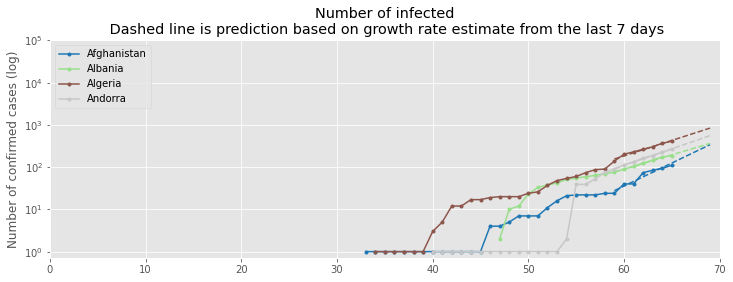

In [36]:
plot_timeline(all_countries[:4],)